In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg import CG, FISTA, POGM, power_iter, FBPD
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dframe, Gmri, Wavelet2D, Diffnd
from mirtorch.prox import Prox, L1Regularizer, Const
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn
import time
%load_ext autoreload
%autoreload 2

In [2]:
# Load the data
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = (Fop.H*k_c).to(torch.complex64).unsqueeze(0)
nx = 320
ny = 320
I1 = I1[:,:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].unsqueeze(0).to(torch.complex64)
mask = torch.zeros(nx,ny)
mask[:,0:ny:4]=1
mask[:,140:180]=1
# mask = torch.ones(nx,ny)

Fop = FFTCn((1, nc, nx, ny), (1, nc, nx, ny), (2,3), norm = 'ortho')
K1 = Fop*I1
K1.requires_grad = True
Sop = Sense(s_c, mask.unsqueeze(0))
I0 = Sop.H*K1
Sop_full = Sense(s_c, torch.ones_like(mask.unsqueeze(0)))
I_gt = Sop_full.H*K1
print('kspace shape', K1.shape)
print('image shape', I0.shape)

kspace shape torch.Size([1, 16, 320, 320])
image shape torch.Size([1, 1, 320, 320])


In [3]:
# Define the wavelet operator
W = Wavelet2D(I0.shape, padding='periodization', J=2, wave_type = 'db4')

In [4]:
# Calculate the step size (Lipschitz)
L = power_iter(Sop, I0, max_iter=200)

The calculation of max singular value accomplished at 14 iterations.
The spectral norm is 0.999932587146759.


In [5]:
# Define the gradient
def gradA(x):
    return Sop.H*Sop*x-I0

def evalation(x):
    return torch.norm(I_gt-x).item()

In [6]:
P = L1Regularizer(1e-5, T = W)

In [7]:
start = time.time()
[pg_wavelet, loss_pg_wavelet] = POGM(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=torch.zeros_like(I0))
print('running time %f s'%(time.time()-start))

running time 4.006825 s


In [8]:
start = time.time()
[fs_wavelet, loss_fs_wavelet] = FISTA(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=torch.zeros_like(I0))
print('running time %f s'%(time.time()-start))

running time 3.713825 s


In [9]:
f_prox = Const()
start = time.time()
[fbpd_wavelet, loss_fbpd_wavelet] = FBPD(gradA, f_prox, P, L[1].item()**2, 1, G=W, max_iter=100, eval_func=evalation).run(I0)
print('running time %f s'%(time.time()-start))

running time 5.583510 s


In [10]:
T = Diffnd(I0.shape, [2,3])
P1 = L1Regularizer(1e-7)
f_prox = Const()
start = time.time()
[fbpd_tv, loss_fbpd_tv] = FBPD(gradA, f_prox, P1, L[1].item()**2, 2.82, G=T, max_iter=100, eval_func=evalation).run(I0)
print('running time %f s'%(time.time()-start))

running time 2.081880 s


Text(0.5, 1.0, 'FISTA-Wavelets Recon')

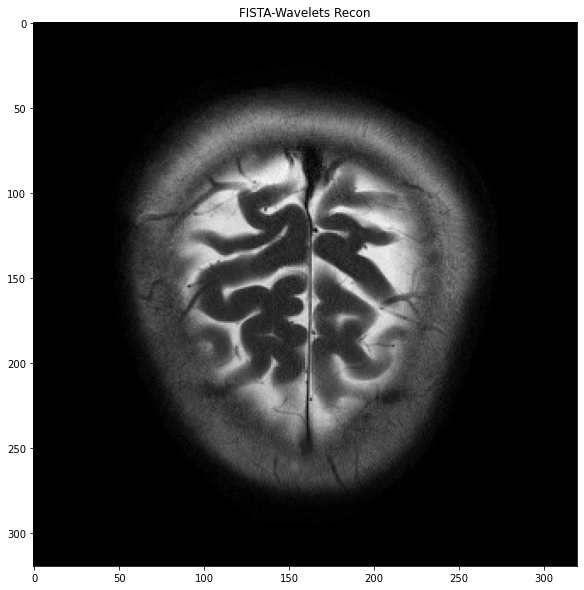

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fs_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FISTA-Wavelets Recon')

Text(0.5, 1.0, 'POGM-Wavelets recon')

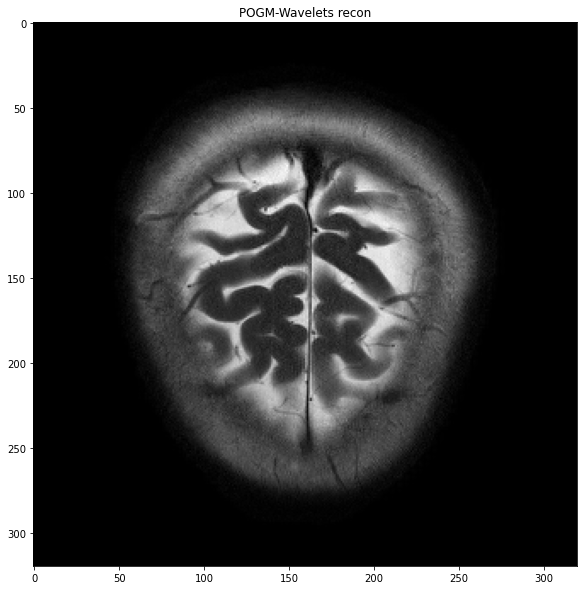

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs((pg_wavelet[0,0,:,:])).cpu().data.numpy(),cmap='gray')
plt.title('POGM-Wavelets recon')

Text(0.5, 1.0, 'FBPD-Wavelets Recon')

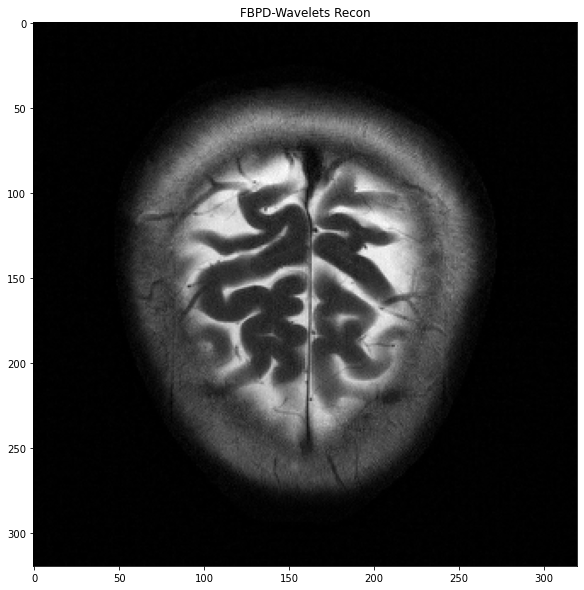

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-Wavelets Recon')

Text(0.5, 1.0, 'FBPD-TV Recon')

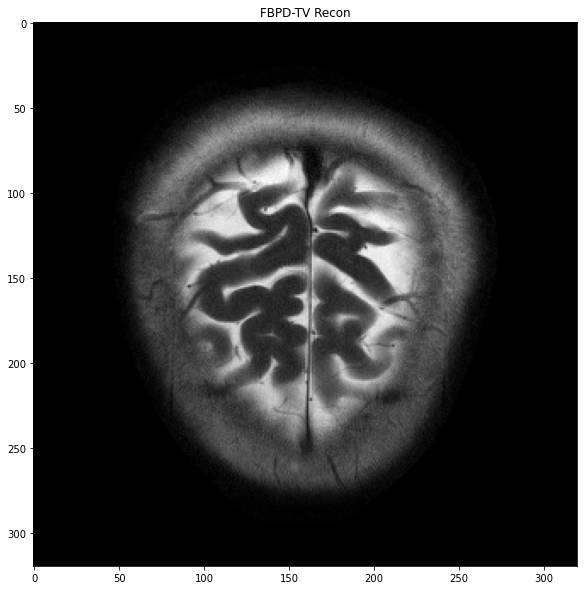

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_tv[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-TV Recon')

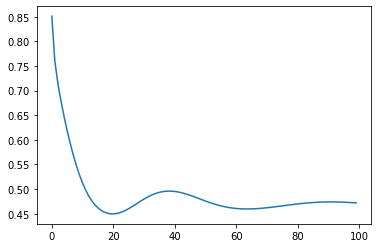

In [15]:
plt.plot(loss_fs_wavelet)

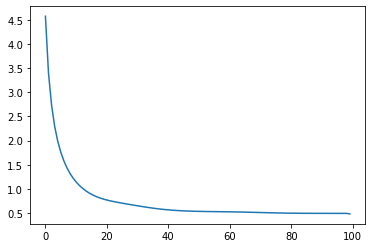

In [16]:
plt.plot(loss_pg_wavelet)

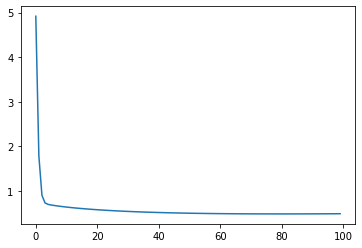

In [17]:
plt.plot(loss_fbpd_wavelet)

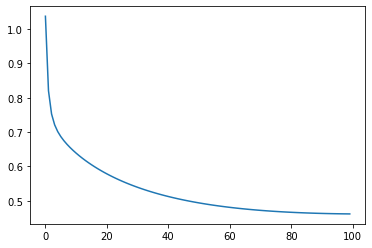

In [18]:
plt.plot(loss_fbpd_tv)